In [1]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools

%matplotlib inline


In [2]:
!pip install efficientnet
import efficientnet.tfkeras as efn 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.1 MB/s eta 0:00:00


In [3]:
import numpy as np
import tensorflow as tf

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)  # Corrected function


## Image Segmentation with KMeans

In [4]:
from skimage.filters import rank, threshold_otsu
from skimage.color import rgb2gray  # Use rgb2gray instead of rgb2grey
from sklearn.cluster import KMeans
from skimage.morphology import closing, square, disk


In [5]:
def plot_any(arr, title = ''):
    """
    plot multiple pictures
    """
    plt.figure(figsize = (15, 25))
    for i in range(len(arr)):
        plt.subplot(1,len(arr),i + 1)
        plt.title(title)
        plt.imshow(arr[i]);

        
def d2Kmeans(img, k):
    """
    Apply 2 dimensional KMeans algorithm on pictures
    """
    return KMeans(n_jobs=-1, 
                  random_state=1, 
                  n_clusters = k, 
                  init='k-means++'
    ).fit(img.reshape((-1,1))).labels_.reshape(img.shape)


def merge_segmented_mask_ROI(uri_img, img_kluster):
    """
    Merge original pricture and segmented picture
    """
    new_img = uri_img.copy()
    for ch in range(3):
        new_img[:,:, ch] *= img_kluster
    return new_img


def mean_filter(image, radius):
    """
    Create smooth boundaries of segmenation thourgh applying a gaussian mean blur
    """
    return rank.mean_percentile(image, selem = disk(radius))


def binary(image):
    """
    Get round boundaries of the image when segmenting
    """
    return image > threshold_otsu(image)


def select_cluster_index(clusters):
    """
    Chooose the right cluster index, which is the smallest, as the rest is background
    """
    minx = clusters[0].mean()
    index = 0
    for i in clusters:
        if i.mean() < minx:
            minx = i.mean()
            index += 1
    return index


def segment_image(img, k = 2):
    """
    segment the image in skin mole versus background
    """
    # Cluster the image
    result_gray = d2Kmeans(rgb2grey(img), k)
    
    # Select the correct cluster
    clusters_gray = [result_gray == i for i in range(k)]
    selected_index = select_cluster_index(clusters_gray)
    results_gray = clusters_gray[selected_index]
    
    # Apply smoothing of the boundaries
    image_mean_filter = mean_filter(results_gray, 20)
    test_binary = binary(image_mean_filter)
    
    # Create segmented picture with black background
    new_img = merge_segmented_mask_ROI(img, test_binary)
    
    return new_img

# Loading & Preprocessing

In [6]:
import os
import numpy as np
import cv2
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

from skimage.color import rgb2gray  # Updated function name
from skimage.filters import rank, threshold_otsu
from skimage.morphology import closing, square, disk
from sklearn.cluster import KMeans

def plot_any(arr, title=''):
    """
    Plot multiple pictures.
    """
    plt.figure(figsize=(15, 25))
    for i in range(len(arr)):
        plt.subplot(1, len(arr), i + 1)
        plt.title(title)
        plt.imshow(arr[i])
    plt.show()

def d2Kmeans(img, k):
    """
    Apply a 2-dimensional KMeans algorithm on the image.
    """
    return KMeans(random_state=1, n_clusters=k, init='k-means++', n_init=10
                 ).fit(img.reshape((-1, 1))).labels_.reshape(img.shape)

def merge_segmented_mask_ROI(uri_img, img_kluster):
    """
    Merge the original image with the segmented mask.
    """
    new_img = uri_img.copy()
    for ch in range(3):
        new_img[:, :, ch] *= img_kluster
    return new_img

def mean_filter(image, radius):
    """
    Create smooth boundaries of segmentation through applying a gaussian mean blur.
    If the input is boolean, it converts it to uint8.
    """
    # Convert boolean images to uint8 (0 or 255)
    if image.dtype == bool:
        image = (image.astype(np.uint8)) * 255
    return rank.mean_percentile(image, footprint=disk(radius))

def binary(image):
    """
    Get rounded boundaries of the image when segmenting.
    """
    return image > threshold_otsu(image)

def select_cluster_index(clusters):
    """
    Choose the correct cluster index. The cluster with the smallest mean is selected as the foreground.
    """
    means = [cluster.mean() for cluster in clusters]
    return np.argmin(means)

def segment_image(img, k=2):
    """
    Segment the image into skin mole versus background.
    """
    # Cluster the image in grayscale
    result_gray = d2Kmeans(rgb2gray(img), k)
    
    # Create binary masks for each cluster
    clusters_gray = [result_gray == i for i in range(k)]
    selected_index = select_cluster_index(clusters_gray)
    results_gray = clusters_gray[selected_index]
    
    # Apply smoothing to the boundaries
    image_mean_filter = mean_filter(results_gray, 20)
    test_binary = binary(image_mean_filter)
    
    # Create segmented image with black background
    new_img = merge_segmented_mask_ROI(img, test_binary)
    
    return new_img

def Dataset_loader(DIR, RESIZE):
    """
    Load images from a directory, resize and segment them.
    """
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR, IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype.lower() == ".jpg":
            img = read(PATH)
            img = cv2.resize(img, (RESIZE, RESIZE))
            img = segment_image(img)
            IMG.append(np.array(img))
    return IMG

# Load datasets
benign_train = np.array(Dataset_loader('../input/skin-cancer-malignant-vs-benign/data/train/benign', 224))
malign_train = np.array(Dataset_loader('../input/skin-cancer-malignant-vs-benign/data/train/malignant', 224))
benign_test = np.array(Dataset_loader('../input/skin-cancer-malignant-vs-benign/data/test/benign', 224))
malign_test = np.array(Dataset_loader('../input/skin-cancer-malignant-vs-benign/data/test/malignant', 224))


100%|██████████| 300/300 [00:38<00:00,  7.78it/s]


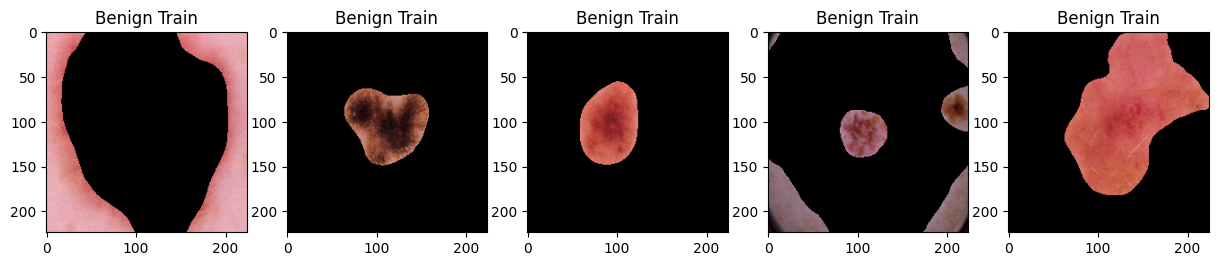

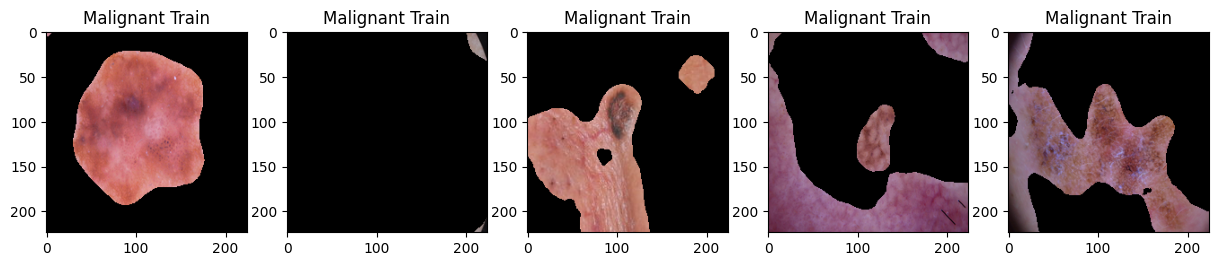

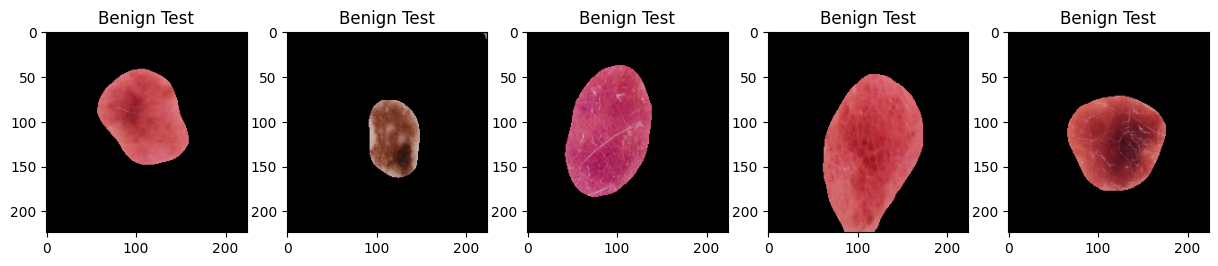

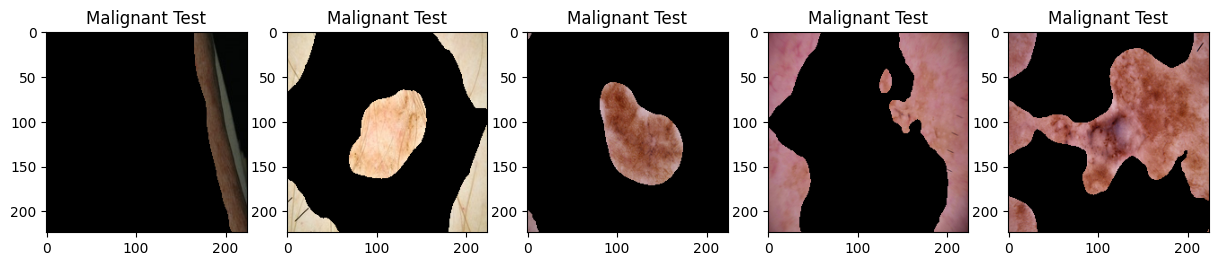

In [7]:
/plot_any(benign_train[:5], title = "Benign Train")
plot_any(malign_train[:5], title = "Malignant Train")
plot_any(benign_test[:5], title = "Benign Test")
plot_any(malign_test[:5], title = "Malignant Test")

# Save all segmented images

In [6]:
!pip install -q efficientnet


In [7]:
!pip install -q efficientnet
import efficientnet.tfkeras as efn


In [1]:
import os
import numpy as np
import cv2
from PIL import Image
import zipfile
from tqdm import tqdm
from skimage.filters import threshold_otsu
from skimage.color import rgb2gray
from sklearn.cluster import KMeans
from skimage.morphology import disk
import matplotlib.pyplot as plt

def d2Kmeans(img, k):
    return KMeans(n_clusters=k, init='k-means++', random_state=1, n_init=10).fit(img.reshape((-1,1))).labels_.reshape(img.shape)

def merge_segmented_mask_ROI(uri_img, img_kluster):
    new_img = uri_img.copy()
    for ch in range(3):
        new_img[:,:, ch] *= img_kluster
    return new_img

def mean_filter(image, radius):
    return cv2.GaussianBlur(image.astype(np.float32), (radius, radius), 0)

def binary(image):
    return image > threshold_otsu(image)

def select_cluster_index(clusters):
    minx = clusters[0].mean()
    index = 0
    for i in range(len(clusters)):
        if clusters[i].mean() < minx:
            minx = clusters[i].mean()
            index = i
    return index

def segment_image(img, k=2):
    result_gray = d2Kmeans(rgb2gray(img), k)
    clusters_gray = [result_gray == i for i in range(k)]
    selected_index = select_cluster_index(clusters_gray)
    results_gray = clusters_gray[selected_index]
    image_mean_filter = mean_filter(results_gray.astype(np.uint8), 21)
    test_binary = binary(image_mean_filter)
    new_img = merge_segmented_mask_ROI(img, test_binary)
    return new_img

def Dataset_loader(DIR, RESIZE, OUTPUT_DIR):
    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)
    
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR, IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype.lower() in [".jpg", ".png", ".jpeg"]:
            img = read(PATH)
            img = cv2.resize(img, (RESIZE, RESIZE))
            segmented_img = segment_image(img)
            output_path = os.path.join(OUTPUT_DIR, IMAGE_NAME)
            cv2.imwrite(output_path, cv2.cvtColor(segmented_img, cv2.COLOR_RGB2BGR))

def zip_folder(folder_path, output_zip):
    with zipfile.ZipFile(output_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(folder_path):
            for file in files:
                zipf.write(os.path.join(root, file), 
                           os.path.relpath(os.path.join(root, file), 
                           os.path.join(folder_path, '..')))

# Define paths
input_base = '/kaggle/input/skin-cancer-malignant-vs-benign'
output_base = '/kaggle/working/segmented_data'
zip_output = '/kaggle/working/segmented_images.zip'

# Process images
Dataset_loader(os.path.join(input_base, 'train/benign'), 224, os.path.join(output_base, 'train/benign'))
Dataset_loader(os.path.join(input_base, 'train/malignant'), 224, os.path.join(output_base, 'train/malignant'))
Dataset_loader(os.path.join(input_base, 'test/benign'), 224, os.path.join(output_base, 'test/benign'))
Dataset_loader(os.path.join(input_base, 'test/malignant'), 224, os.path.join(output_base, 'test/malignant'))

# Zip the segmented dataset
zip_folder(output_base, zip_output)

print(f"Segmented images saved and zipped at {zip_output}")


100%|██████████| 300/300 [00:27<00:00, 11.07it/s]


Segmented images saved and zipped at /kaggle/working/segmented_images.zip
